# Recommendation System - Model 1

## Import packages and dataframes

In [117]:
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

rd.seed(123)

In [2]:
# import all the files

donationsDF = pd.read_csv('Donations.csv')
donorsDF = pd.read_csv('Donors.csv')
projectsDF = pd.read_csv('Projects.csv')
schoolsDF = pd.read_csv('Schools.csv')
resourcesDF = pd.read_csv('Resources.csv')

/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Snapshot of the dataframes

In [3]:
donationsDF.head(2)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23


In [4]:
donorsDF.head(2)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245


In [5]:
projectsDF.head(2)

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch...",Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,Fully Funded,2013-01-11
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Learning in Color!,"Help us have a fun, interactive listening cent...","Help us have a fun, interactive listening cent...","My students need a listening center, read alon...","Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,Expired,NaN


## Remove one-time donors

In [6]:
donorsDF_merged = donorsDF.merge(donationsDF, on = 'Donor ID', how = 'inner') # donation ID is the primary key here

In [7]:
donorsDF_merged.head(1)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602,5bab6101eed588c396a59f6bd64274b6,598691d82438952e2e4f3ed50531fd2a,Yes,50.0,1,2013-12-17 21:47:14


In [8]:
# Get the count of donations a donor has made

df_temp1 = donorsDF_merged.groupby( ['Donor ID']).size().reset_index(name='Num Donations')

df_temp1.head(2)

,Donor ID,Num Donations
0,00000ce845c00cbf0686c992fc369df4,1
1,00002783bc5d108510f3f9666c8b1edd,1


In [9]:
df_temp2 = df_temp1[df_temp1['Num Donations'] > 1] # removing all the single-donors

print("We got rid of %d single-donors." % (df_temp1.shape[0] - df_temp2.shape[0]))

We got rid of 1466290 single-donors.


## Building dataframe for modeling

In [10]:
uniqDonorIDList = list(df_temp2['Donor ID']) # list of recurring donors
df_final = donorsDF_merged[donorsDF_merged['Donor ID'].isin(uniqDonorIDList)]


df_final.shape

(3215610, 11)

In [11]:
df_final = df_final.drop_duplicates(subset = ['Donation ID']) # removes duplicate Donation IDs

df_final.shape

(3215570, 11)

In [12]:
df_final = df_final.merge(projectsDF, on = "Project ID", how = "inner") # adding projects to the final dataframe

df_final.head(2)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,...,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,7831f66a25935db8b7424170355edabf,No,26.0,10,...,My students need books to inspire them to be a...,"History & Civics, Literacy & Language","Civics & Government, Literacy",Grades 6-8,Books,373.53,2017-04-01,2017-08-01,Fully Funded,2017-05-12
1,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,ee15bb7f179142fdff3f24cff8e88483,No,100.0,9,...,My students need books to inspire them to be a...,"History & Civics, Literacy & Language","Civics & Government, Literacy",Grades 6-8,Books,373.53,2017-04-01,2017-08-01,Fully Funded,2017-05-12


In [13]:
df_final = df_final.merge(schoolsDF, on = "School ID", how = "inner") # adding projects to the final dataframe

df_final.head(2)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
0,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,7831f66a25935db8b7424170355edabf,No,26.0,10,...,Fully Funded,2017-05-12,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
1,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,ee15bb7f179142fdff3f24cff8e88483,No,100.0,9,...,Fully Funded,2017-05-12,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District


### Training and test split

In [14]:
columnsList = ['Donor ID', 'Donation Received Date', 'Donor City', 'Donor State',
       'Donor Is Teacher', 'Donor Zip', 'Project ID', 'Donation ID',
       'Donation Included Optional Donation', 'Donation Amount',
       'Donor Cart Sequence', 'School ID', 'Teacher ID',
       'Teacher Project Posted Sequence', 'Project Type', 'Project Title',
       'Project Essay', 'Project Short Description', 'Project Need Statement',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Posted Date', 'Project Expiration Date',
       'Project Current Status', 'Project Fully Funded Date', 'School Name',
       'School Metro Type', 'School Percentage Free Lunch', 'School State',
       'School Zip', 'School City', 'School County', 'School District']

df_final = df_final[columnsList]

df_final = df_final.sort_values(by = ['Donor ID', 'Donation Received Date']) # sorts dataframe by donors and their
                                                                            # first donation date


In [156]:
df_final.columns

Index(['Donor ID', 'Donation Received Date', 'Donor City', 'Donor State',
       'Donor Is Teacher', 'Donor Zip', 'Project ID', 'Donation ID',
       'Donation Included Optional Donation', 'Donation Amount',
       'Donor Cart Sequence', 'School ID', 'Teacher ID',
       'Teacher Project Posted Sequence', 'Project Type', 'Project Title',
       'Project Essay', 'Project Short Description', 'Project Need Statement',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Posted Date', 'Project Expiration Date',
       'Project Current Status', 'Project Fully Funded Date', 'School Name',
       'School Metro Type', 'School Percentage Free Lunch', 'School State',
       'School Zip', 'School City', 'School County', 'School District'],
      dtype='object')

In [15]:
donorsKeep = df_final.drop_duplicates(subset=['Donor ID'], keep='first') # keep just the first donation for each donor

donorsKeep = donorsKeep.sort_values(['Donation Received Date']) # sort the donation by donation date

donorsKeep.head(5)

,Donor ID,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
2233258,fcf96e729bf1b03dfbd8f07a3b4ee173,2012-10-08 13:53:00,Staten Island,New York,Yes,103,3cef9c6b38eb98b50ab9d82616a95fef,fdb6b2832434cba2fc52452829ca28d1,Yes,25.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2233253,ea1db63aa514055a1faa005e4f37df5f,2012-10-08 18:44:11,Staten Island,New York,No,103,3cef9c6b38eb98b50ab9d82616a95fef,894e5893a7f544e283284e556b3524fc,No,50.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2233255,f5c13e4c10889c2d171d955e9908859e,2012-10-08 19:34:08,Staten Island,New York,No,103,3cef9c6b38eb98b50ab9d82616a95fef,5ccff2917509fe2f4e6b163f35952f59,No,10.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2757295,2f46f2a396311a0b73d7550a8c945211,2012-10-09 16:54:45,NaN,New York,No,100,2a84cb3c1439994b368f4b51dc099678,60cf97b0d67b92e22b00f8f9914fb1f0,No,50.0,...,Fully Funded,2013-02-18,Confluence Prep Academy,urban,90.0,Missouri,63103,Saint Louis,St Louis City,Missouri Dept Of Education
2757319,f9f9312786079a621fec74f35ea75606,2012-10-10 22:24:21,Saint Louis,Missouri,Yes,631,2a84cb3c1439994b368f4b51dc099678,0e792579fbe9b81f04e2fab8eda822d1,Yes,20.0,...,Fully Funded,2013-02-18,Confluence Prep Academy,urban,90.0,Missouri,63103,Saint Louis,St Louis City,Missouri Dept Of Education


In [16]:
donationsTrainNum = int(round(0.8 * len(donorsKeep), 0)) # the top ~80% is the training data

In [17]:
donationsTrain = donorsKeep.iloc[:donationsTrainNum,:]

donationsValid = donorsKeep.iloc[donationsTrainNum:,] # the bottom ~20% is the validation data

In [18]:
donationsTrain.head(5)

,Donor ID,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
2233258,fcf96e729bf1b03dfbd8f07a3b4ee173,2012-10-08 13:53:00,Staten Island,New York,Yes,103,3cef9c6b38eb98b50ab9d82616a95fef,fdb6b2832434cba2fc52452829ca28d1,Yes,25.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2233253,ea1db63aa514055a1faa005e4f37df5f,2012-10-08 18:44:11,Staten Island,New York,No,103,3cef9c6b38eb98b50ab9d82616a95fef,894e5893a7f544e283284e556b3524fc,No,50.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2233255,f5c13e4c10889c2d171d955e9908859e,2012-10-08 19:34:08,Staten Island,New York,No,103,3cef9c6b38eb98b50ab9d82616a95fef,5ccff2917509fe2f4e6b163f35952f59,No,10.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2757295,2f46f2a396311a0b73d7550a8c945211,2012-10-09 16:54:45,NaN,New York,No,100,2a84cb3c1439994b368f4b51dc099678,60cf97b0d67b92e22b00f8f9914fb1f0,No,50.0,...,Fully Funded,2013-02-18,Confluence Prep Academy,urban,90.0,Missouri,63103,Saint Louis,St Louis City,Missouri Dept Of Education
2757319,f9f9312786079a621fec74f35ea75606,2012-10-10 22:24:21,Saint Louis,Missouri,Yes,631,2a84cb3c1439994b368f4b51dc099678,0e792579fbe9b81f04e2fab8eda822d1,Yes,20.0,...,Fully Funded,2013-02-18,Confluence Prep Academy,urban,90.0,Missouri,63103,Saint Louis,St Louis City,Missouri Dept Of Education


In [19]:
donorsTrainList = list(donationsTrain['Donor ID'])

# donorsTrainList

In [20]:
donationsTrainFinal = df_final[df_final['Donor ID'].isin(donorsTrainList)] # expanding the training data

In [21]:
donationsTrainFinal = donationsTrainFinal.sort_values(by = ['Donor ID', 'Donation Received Date']) 

donationsTrainFinal.head(10)

,Donor ID,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
9,00002d44003ed46b066607c5455a999a,2016-10-25 20:15:11,Winton,California,Yes,953,e2beb818569f66adaa4ced21ca299ac6,08ed72ce14c548e8131a7dd7b8561988,Yes,10.00,...,Fully Funded,2016-12-26,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
500,00002d44003ed46b066607c5455a999a,2017-01-16 01:11:20,Winton,California,Yes,953,eb6d91cbeab5037ca2f45fc3f6a4de8c,158f00637416b7c41fcde429b10c3c41,Yes,15.51,...,Fully Funded,2017-01-16,Clara B Ford Academy,suburban,95.0,Michigan,48127,Dearborn Hts,Wayne,Michigan Dept Of Education
164,00002d44003ed46b066607c5455a999a,2017-01-16 14:20:10,Winton,California,Yes,953,64f54f1efcbeb986114a7a13e6b27257,e3162fdec64ed91de1aa096cf75ba032,Yes,100.00,...,Expired,NaN,Donn B Chenoweth Elementary School,urban,57.0,California,95340,Merced,Merced,Merced City School District
175,00002d44003ed46b066607c5455a999a,2017-01-16 14:26:19,Winton,California,Yes,953,dfdaf35bb33f9c105530c82984960ff3,45ffd222223dfb2ed7728014eafe328c,Yes,9.69,...,Fully Funded,2017-01-16,Shoally Creek Elementary,unknown,61.0,South Carolina,29316,Boiling Spgs,Spartanburg,Spartanburg School District 2
25,00002d44003ed46b066607c5455a999a,2017-01-16 15:46:57,Winton,California,Yes,953,2f7996f08052785e9b146f72c0c4990d,c73207489356a7bcf3ef0b8660c61b04,Yes,13.75,...,Fully Funded,2017-01-16,Portland Elementary School,urban,92.0,Kentucky,40212,Louisville,Jefferson,Jefferson Co School District
3,00002d44003ed46b066607c5455a999a,2017-02-01 18:53:25,Winton,California,Yes,953,e09933470f4256cc2643341c1d299e55,93c0af8b821e432857e5a63687524dd9,No,150.00,...,Fully Funded,2017-02-19,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
4,00002d44003ed46b066607c5455a999a,2017-02-03 14:20:57,Winton,California,Yes,953,e09933470f4256cc2643341c1d299e55,23d388c20fb9ba1a714632d51aa8ad32,No,10.00,...,Fully Funded,2017-02-19,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
1,00002d44003ed46b066607c5455a999a,2017-04-01 01:08:50,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,ee15bb7f179142fdff3f24cff8e88483,No,100.00,...,Fully Funded,2017-05-12,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
0,00002d44003ed46b066607c5455a999a,2017-05-02 12:34:09,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,7831f66a25935db8b7424170355edabf,No,26.00,...,Fully Funded,2017-05-12,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
171,00002d44003ed46b066607c5455a999a,2017-10-18 14:34:11,Winton,California,Yes,953,c5821d32012efd7df4f6fa12e230e991,615d39f9c40cd3137a9854c29ad0dbe2,No,100.00,...,Fully Funded,2017-12-10,ADA Givens Elementary School,urban,81.0,California,95340,Merced,Merced,Merced City School District


In [22]:
donorsValidList = list(donationsValid['Donor ID'])

donationsValidFinal = df_final[df_final['Donor ID'].isin(donorsValidList)] # expanding the validation data as well

donationsValidFinal = donationsValidFinal.sort_values(by = ['Donor ID', 'Donation Received Date'])

donationsValidFinal.head(10)

,Donor ID,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
1523,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:19,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,0e7de979325e84ad03163e26d59c075a,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1515,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,4768c31e21e89f79ada2a05e7b1336df,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1518,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,7e436d1b26e60246a9bd81ac059c6e9b,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1519,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,698df43826119cf99d9f24488039dd64,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1521,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,6a618527b395daf5830e41ea4417341d,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1522,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,aca915b2420c0b1851da1e42642e9e27,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1516,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:21,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,7001340658440b07f622d175c6991179,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1517,00006084c3d92d904a22e0a70f5c119a,2017-04-09 17:57:41,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,dc010aa5685ccfb8d6db4098730bae57,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1525,00006084c3d92d904a22e0a70f5c119a,2017-04-09 17:58:43,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,bfc1f1fc38ff8b57894f283afb8fc29d,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1520,00006084c3d92d904a22e0a70f5c119a,2017-04-09 17:59:32,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,f0ae22e51a49d1f54b5d50a0b0a11910,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd


In [23]:
print("Training data shape: \n", donationsTrainFinal.shape)
print("Validation data shape: \n", donationsValidFinal.shape)

Training data shape: 
 (2711805, 36)
Validation data shape: 
 (445059, 36)


## One-Hot Vectorization of Features

In [24]:
# checking for null values in the dataframe

trainNullCol = donationsTrainFinal.columns[donationsTrainFinal.isnull().any()]
donationsTrainFinal[trainNullCol].isnull().sum()

Donor City                          119127
Donor Zip                            69242
Project Title                           18
Project Essay                            6
Project Short Description                7
Project Subject Category Tree           76
Project Subject Subcategory Tree        76
Project Resource Category               89
Project Expiration Date                  1
Project Fully Funded Date           254865
School Percentage Free Lunch          8137
School City                          16736
School County                           17
dtype: int64

In [90]:
# because we are doing content-based filtering, here are the features of the projects we are interested in:

ohFeatures = ['Project ID', 'Project Expiration Date', 'Project Cost', 'Project Type','Project Subject Category Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Current Status',
       'School Metro Type', 'School State']

In [91]:
# drop duplicates of projects because 'Project ID' has to be the primary key

projFeatures = donationsTrainFinal[ohFeatures].drop_duplicates(subset = ['Project ID'])

projFeatures = projFeatures.dropna() # drop the null values as well

print(projFeatures.shape)

(748834, 10)


In [92]:
# no null values or duplicates

trainNullCol = projFeatures.columns[projFeatures.isnull().any()]
projFeatures[trainNullCol].isnull().sum()

Series([], dtype: float64)

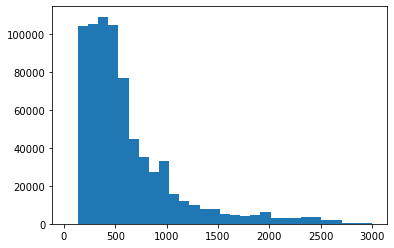

In [154]:
test = projFeatures['Project Cost']

plt.hist(test[test <= 3000], bins = 30)
plt.show()

In [97]:
enc = OHE(handle_unknown='ignore')
enc.fit(projFeatures.iloc[:,3:]) # fit the one hot vector on our dataframe

OneHotEncoder(handle_unknown='ignore')

In [98]:
enc.categories_ # data dictionary of the OHM

[array(['Professional Development', 'Student-Led', 'Teacher-Led'],
       dtype=object),
 array(['Applied Learning', 'Applied Learning, Health & Sports',
        'Applied Learning, History & Civics',
        'Applied Learning, Literacy & Language',
        'Applied Learning, Math & Science',
        'Applied Learning, Music & The Arts',
        'Applied Learning, Special Needs',
        'Applied Learning, Warmth, Care & Hunger', 'Health & Sports',
        'Health & Sports, Applied Learning',
        'Health & Sports, History & Civics',
        'Health & Sports, Literacy & Language',
        'Health & Sports, Math & Science',
        'Health & Sports, Music & The Arts',
        'Health & Sports, Special Needs',
        'Health & Sports, Warmth, Care & Hunger', 'History & Civics',
        'History & Civics, Applied Learning',
        'History & Civics, Health & Sports',
        'History & Civics, Literacy & Language',
        'History & Civics, Math & Science',
        'History & Civics,

In [100]:
oneHotMatrix = pd.DataFrame(enc.transform(projFeatures.iloc[:,3:]).toarray()) # convert the one-hot matrix into a dataframe

In [101]:
# this is what the OHM looks like

oneHotMatrix

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748829,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748830,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748831,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748832,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Merging one-hot matrix with the dataframe

In [108]:
projOHM = pd.concat([projFeatures.reset_index(drop = True), oneHotMatrix.reset_index(drop = True)], axis = 1)

projOHM.head(5)


,Project ID,Project Expiration Date,Project Cost,Project Type,Project Subject Category Tree,Project Grade Level Category,Project Resource Category,Project Current Status,School Metro Type,School State,...,125,126,127,128,129,130,131,132,133,134
0,e2beb818569f66adaa4ced21ca299ac6,2017-02-22,555.28,Teacher-Led,"History & Civics, Literacy & Language",Grades 6-8,Books,Fully Funded,urban,California,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,eb6d91cbeab5037ca2f45fc3f6a4de8c,2017-05-12,305.51,Teacher-Led,"Warmth, Care & Hunger",Grades 6-8,Supplies,Fully Funded,suburban,Michigan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,64f54f1efcbeb986114a7a13e6b27257,2017-03-12,596.98,Teacher-Led,"Applied Learning, Special Needs",Grades PreK-2,Supplies,Expired,urban,California,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dfdaf35bb33f9c105530c82984960ff3,2017-01-27,513.22,Teacher-Led,Music & The Arts,Grades 3-5,Supplies,Fully Funded,unknown,South Carolina,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2f7996f08052785e9b146f72c0c4990d,2017-01-22,369.64,Teacher-Led,"Math & Science, Applied Learning",Grades PreK-2,Technology,Fully Funded,urban,Kentucky,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
dropCol = ['Project Type', 'Project Subject Category Tree', 'Project Grade Level Category',
           'Project Resource Category', 'Project Current Status',
           'School Metro Type', 'School State']

In [110]:
# because we wanted to keep the project cost as one of the features,
# we vectorized the rest of features and vertically stacked the project cost

projOHM = projOHM.drop(dropCol, axis = 1)

projOHM.head(5)

,Project ID,Project Expiration Date,Project Cost,0,1,2,3,4,5,6,...,125,126,127,128,129,130,131,132,133,134
0,e2beb818569f66adaa4ced21ca299ac6,2017-02-22,555.28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,eb6d91cbeab5037ca2f45fc3f6a4de8c,2017-05-12,305.51,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,64f54f1efcbeb986114a7a13e6b27257,2017-03-12,596.98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dfdaf35bb33f9c105530c82984960ff3,2017-01-27,513.22,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2f7996f08052785e9b146f72c0c4990d,2017-01-22,369.64,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
# data dictionary to track the one hot matrix

dataDict = enc.get_feature_names(dropCol) # please note that any new input should strictly should the indexes
                                            # mentioned in data dictionary

## Building the recommendation system

In [114]:
# scale and normalize the dataset

ohmDF = pd.DataFrame(StandardScaler().fit_transform(projOHM.iloc[:,2:]))

ohmDFwProj = pd.concat([projOHM[['Project ID', 'Project Expiration Date']], ohmDF], axis = 1)

ohmDFwProj.head(5) # column here is a OH feature

,Project ID,Project Expiration Date,0,1,2,3,4,5,6,7,...,126,127,128,129,130,131,132,133,134,135
0,e2beb818569f66adaa4ced21ca299ac6,2017-02-22,-0.119034,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
1,eb6d91cbeab5037ca2f45fc3f6a4de8c,2017-05-12,-0.362253,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
2,64f54f1efcbeb986114a7a13e6b27257,2017-03-12,-0.078427,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
3,dfdaf35bb33f9c105530c82984960ff3,2017-01-27,-0.159991,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
4,2f7996f08052785e9b146f72c0c4990d,2017-01-22,-0.299805,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785


## Testing the recommendation system with a sample row

In [206]:
# taking the first row as a sample row for the recommendation system

testRow = np.array(ohmDFwProj[ohmDFwProj['Project ID'] == '3cef9c6b38eb98b50ab9d82616a95fef'].iloc[:,1:])

testRow

array([['2013-02-23', 2.630456919250857, -0.09662685834874933,
        -0.08812006240336985, 0.13133220512451135, -0.19903278549403178,
        -0.0776930620937543, -0.05414592784862258, -0.16956109547045767,
        -0.10825473553063442, -0.09975315339466358, -0.1377924073170339,
        -0.00589252503280833, -0.2054220132178528, -0.038668076113368526,
        -0.017025505855864733, -0.06704530052314935,
        -0.037596848478980635, -0.03636573323746134,
        -0.09626011975670562, -0.008333433495395549, 7.316288066341166,
        -0.023405508208557906, -0.012447148116639757,
        -0.13573029609108808, -0.06855600096346315, -0.06636868104879486,
        -0.04686384233428239, -0.0023112045199013696,
        -0.5487446638754125, -0.08320021837144562, -0.026613310530192728,
        -0.10915397909047732, -0.3938635598196957, -0.14568007440632386,
        -0.19788057671698656, -0.005892525032808331,
        -0.41860880685479085, -0.11800246586881326,
        -0.058638238597606786, -

In [115]:
ohmDFwProj.head(5)

,Project ID,Project Expiration Date,0,1,2,3,4,5,6,7,...,126,127,128,129,130,131,132,133,134,135
0,e2beb818569f66adaa4ced21ca299ac6,2017-02-22,-0.119034,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
1,eb6d91cbeab5037ca2f45fc3f6a4de8c,2017-05-12,-0.362253,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
2,64f54f1efcbeb986114a7a13e6b27257,2017-03-12,-0.078427,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
3,dfdaf35bb33f9c105530c82984960ff3,2017-01-27,-0.159991,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
4,2f7996f08052785e9b146f72c0c4990d,2017-01-22,-0.299805,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785


In [233]:
# getting the cosine similarity between our feature matrix and test sample

test2 = cosine_similarity(ohmDF, np.array([testRow[0][1:]]))

test2

array([[ 0.05133915],
       [ 0.0062936 ],
       [-0.0495861 ],
       ...,
       [-0.02853252],
       [-0.05765878],
       [-0.03658364]])

In [234]:
# tracing back the cosine similarity with their corresponding project ID
# so that we know what project does the similarity correspond to

test3 = pd.concat([projOHM.iloc[:,:1], pd.DataFrame(test2)], axis = 1)

test3 = test3.sort_values(by = 0, ascending = False) # sorting the similarity in descending order

test3.columns = ['Project ID', 'Cosine Similarity']

top10Rec = list(test3.head(11).iloc[1:,:]['Project ID'])

test3.head(11)

,Project ID,Cosine Similarity
170271,3cef9c6b38eb98b50ab9d82616a95fef,1.000000
114313,431edad02a4797f303dfbcd18493e2a7,0.998557
244906,a24d6991c07ecb939b30f2855438da0a,0.998280
67210,7226568095dacc94be06cf76753a2391,0.994437
80281,c83f962d03001868d5420c8b0ba36065,0.990401
16870,c6884836e7923417f063e31c0f416baa,0.989306
696314,4f993a5ac32fcab50223127568d6e3d8,0.986821
616590,8b637975035d004fd64810c887542c75,0.985751
156567,b24c99ab36c3736acb2526de682b1561,0.979065
127994,b6cd8c37aa96fa74b30577371b60db94,0.979065


In [80]:
# checking if the recommendation system fares well
# here the recommended project has the same features, except the project cost

projFeatures[projFeatures['Project ID'] == '3cef9c6b38eb98b50ab9d82616a95fef']

,Project ID,Project Cost,Project Type,Project Subject Category Tree,Project Grade Level Category,Project Resource Category,Project Current Status,School Metro Type,School State
2233245,3cef9c6b38eb98b50ab9d82616a95fef,3378.82,Teacher-Led,History & Civics,Grades 6-8,Trips,Fully Funded,urban,New York


In [81]:
# checking if the recommendation system fares well v2

projFeatures[projFeatures['Project ID'] == 'a24d6991c07ecb939b30f2855438da0a']

,Project ID,Project Cost,Project Type,Project Subject Category Tree,Project Grade Level Category,Project Resource Category,Project Current Status,School Metro Type,School State
2402926,a24d6991c07ecb939b30f2855438da0a,2662.35,Teacher-Led,History & Civics,Grades 6-8,Trips,Fully Funded,urban,New York


In [181]:
donorID = np.array(donorsKeep['Donor ID'])

donorID.shape

(551989,)

In [183]:
def donatedProjects(donorID):
    donatedProjectsDict = {}
    
    for i in donorID[:100].tolist():
        
        donor_donated_projs = list(df_final[df_final['Donor ID'] == i]['Project ID'])
        donatedProjectsDict[i] = donor_donated_projs

    return donatedProjectsDict

        
donatedProjs = donatedProjects(donorID)

In [211]:
donatedProjsDF = pd.DataFrame.from_dict(donatedProjs, orient='index').reset_index()

donatedProjsDF = donatedProjsDF.rename(columns = {"index" : "Donor ID", 0:"Project ID"})

In [237]:
firstProjDonated = donatedProjsDF.iloc[:,:2]
          
firstProjDonated.head(5)

,Donor ID,Project ID
0,fcf96e729bf1b03dfbd8f07a3b4ee173,3cef9c6b38eb98b50ab9d82616a95fef
1,ea1db63aa514055a1faa005e4f37df5f,3cef9c6b38eb98b50ab9d82616a95fef
2,f5c13e4c10889c2d171d955e9908859e,3cef9c6b38eb98b50ab9d82616a95fef
3,2f46f2a396311a0b73d7550a8c945211,2a84cb3c1439994b368f4b51dc099678
4,f9f9312786079a621fec74f35ea75606,2a84cb3c1439994b368f4b51dc099678


In [215]:
firstProjOHM = pd.merge(firstProjDonated, ohmDFwProj, on = 'Project ID', how = 'inner')

firstProjOHM.head(5)

,Donor ID,Project ID,Project Expiration Date,0,1,2,3,4,5,6,...,126,127,128,129,130,131,132,133,134,135
0,fcf96e729bf1b03dfbd8f07a3b4ee173,3cef9c6b38eb98b50ab9d82616a95fef,2013-02-23,2.630457,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
1,ea1db63aa514055a1faa005e4f37df5f,3cef9c6b38eb98b50ab9d82616a95fef,2013-02-23,2.630457,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
2,f5c13e4c10889c2d171d955e9908859e,3cef9c6b38eb98b50ab9d82616a95fef,2013-02-23,2.630457,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
3,7052a3ea47c86c9c6c3e26fdb60e285c,3cef9c6b38eb98b50ab9d82616a95fef,2013-02-23,2.630457,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
4,342a12d6c0ccbf4ae642f73d22a93bd3,3cef9c6b38eb98b50ab9d82616a95fef,2013-02-23,2.630457,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785


In [238]:
projOHM.head(5)

,Project ID,Project Expiration Date,Project Cost,0,1,2,3,4,5,6,...,125,126,127,128,129,130,131,132,133,134
0,e2beb818569f66adaa4ced21ca299ac6,2017-02-22,555.28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,eb6d91cbeab5037ca2f45fc3f6a4de8c,2017-05-12,305.51,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,64f54f1efcbeb986114a7a13e6b27257,2017-03-12,596.98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dfdaf35bb33f9c105530c82984960ff3,2017-01-27,513.22,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2f7996f08052785e9b146f72c0c4990d,2017-01-22,369.64,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [244]:
ohmDF.head(5)

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,-0.119034,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,-0.108255,-0.099753,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
1,-0.362253,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,-0.108255,-0.099753,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
2,-0.078427,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,-0.108255,-0.099753,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
3,-0.159991,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,-0.108255,-0.099753,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785
4,-0.299805,-0.096627,-0.08812,0.131332,-0.199033,-0.077693,-0.054146,-0.169561,-0.108255,-0.099753,...,-0.05082,-0.130419,-0.257288,-0.11009,-0.035414,-0.147628,-0.151159,-0.0696,-0.124467,-0.030785


In [245]:
cosineSim = cosine_similarity(ohmDF, firstProjOHM.iloc[:,3:])
cosineSim.shape

pd.DataFrame(cosineSim)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.051339,0.051339,0.051339,0.051339,0.051339,0.051339,0.051339,-0.024198,-0.024198,-0.024198,...,0.150952,0.085168,0.029718,-0.060463,-0.056887,-0.014688,-0.067746,0.011243,0.011243,-0.045271
1,0.006294,0.006294,0.006294,0.006294,0.006294,0.006294,0.006294,-0.050674,-0.050674,-0.050674,...,0.014128,-0.084007,0.024495,-0.033334,-0.092888,-0.025101,-0.011049,-0.010192,-0.010192,-0.024610
2,-0.049586,-0.049586,-0.049586,-0.049586,-0.049586,-0.049586,-0.049586,-0.043581,-0.043581,-0.043581,...,0.031551,-0.104333,-0.119360,-0.035980,-0.035159,-0.008671,-0.007480,-0.091675,-0.091675,0.040556
3,-0.060795,-0.060795,-0.060795,-0.060795,-0.060795,-0.060795,-0.060795,-0.057761,-0.057761,-0.057761,...,-0.066800,-0.123240,0.125348,0.052153,-0.139146,-0.037345,-0.016938,-0.111886,-0.111886,-0.037869
4,-0.018224,-0.018224,-0.018224,-0.018224,-0.018224,-0.018224,-0.018224,-0.026248,-0.026248,-0.026248,...,0.507135,-0.033345,-0.003931,-0.042716,0.080947,0.022758,-0.015215,-0.024665,-0.024665,0.011219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748829,-0.056162,-0.056162,-0.056162,-0.056162,-0.056162,-0.056162,-0.056162,-0.056584,-0.056584,-0.056584,...,-0.059985,-0.111062,0.109073,-0.046728,-0.044924,-0.011592,0.027957,-0.027332,-0.027332,0.028543
748830,-0.016219,-0.016219,-0.016219,-0.016219,-0.016219,-0.016219,-0.016219,-0.010013,-0.010013,-0.010013,...,-0.021751,-0.041876,-0.006087,-0.057340,0.102328,0.029156,-0.020523,-0.035219,-0.035219,0.373848
748831,-0.028533,-0.028533,-0.028533,-0.028533,-0.028533,-0.028533,-0.028533,0.035879,0.035879,0.035879,...,-0.039361,0.056242,0.007734,-0.088935,-0.011046,-0.002057,-0.039974,-0.067965,-0.067965,-0.067217
748832,-0.057659,-0.057659,-0.057659,-0.057659,-0.057659,-0.057659,-0.057659,0.000455,0.000455,0.000455,...,-0.056350,0.076335,0.011829,-0.126130,-0.012540,-0.002819,-0.057029,-0.092940,-0.092940,-0.094203


In [253]:
cosineSimMerged = pd.concat([projOHM.iloc[:,:3], pd.DataFrame(cosineSim)], axis = 1)

cosineSimMerged = cosineSimMerged.rename(columns = {"Project ID": "Recommended Projects"})

cosineSimMerged.head(5)

,Recommended Projects,Project Expiration Date,Project Cost,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,e2beb818569f66adaa4ced21ca299ac6,2017-02-22,555.28,0.051339,0.051339,0.051339,0.051339,0.051339,0.051339,0.051339,...,0.150952,0.085168,0.029718,-0.060463,-0.056887,-0.014688,-0.067746,0.011243,0.011243,-0.045271
1,eb6d91cbeab5037ca2f45fc3f6a4de8c,2017-05-12,305.51,0.006294,0.006294,0.006294,0.006294,0.006294,0.006294,0.006294,...,0.014128,-0.084007,0.024495,-0.033334,-0.092888,-0.025101,-0.011049,-0.010192,-0.010192,-0.024610
2,64f54f1efcbeb986114a7a13e6b27257,2017-03-12,596.98,-0.049586,-0.049586,-0.049586,-0.049586,-0.049586,-0.049586,-0.049586,...,0.031551,-0.104333,-0.119360,-0.035980,-0.035159,-0.008671,-0.007480,-0.091675,-0.091675,0.040556
3,dfdaf35bb33f9c105530c82984960ff3,2017-01-27,513.22,-0.060795,-0.060795,-0.060795,-0.060795,-0.060795,-0.060795,-0.060795,...,-0.066800,-0.123240,0.125348,0.052153,-0.139146,-0.037345,-0.016938,-0.111886,-0.111886,-0.037869
4,2f7996f08052785e9b146f72c0c4990d,2017-01-22,369.64,-0.018224,-0.018224,-0.018224,-0.018224,-0.018224,-0.018224,-0.018224,...,0.507135,-0.033345,-0.003931,-0.042716,0.080947,0.022758,-0.015215,-0.024665,-0.024665,0.011219


In [ ]:
# tracing back the cosine similarity with their corresponding project ID
# so that we know what project does the similarity correspond to

test3 = pd.concat([projOHM.iloc[:,:1], pd.DataFrame(test2)], axis = 1)

test3 = test3.sort_values(by = 0, ascending = False) # sorting the similarity in descending order

test3.columns = ['Project ID', 'Cosine Similarity']

top10Rec = list(test3.head(11).iloc[1:,:]['Project ID'])

test3.head(11)

In [82]:
donor_donated_projs = list(df_final[df_final['Donor ID'] == 'fcf96e729bf1b03dfbd8f07a3b4ee173']['Project ID'])

In [83]:
hits = 0
donationCount = []

for i in donor_donated_projs:
    if i not in donationCount: # eliminates repetitive donations to the same recommended project
        donationCount.append(i)
        if i in top10Rec:
            hits += 1
        
        
print("Our model got %d hits out of %d projects that the donor has donated." % (hits, len(donor_donated_projs)))

Our model got 1 hits out of 6 projects that the donor has donated.
